In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/MDS.py

In [5]:
protein_name = 'fxa'

In [6]:
path_to_file = '../../../FXa/ANALISIS/1_Fetching_and_generating_data/TABLA_MTDATA_FXA_136_crys_LIGS_INFO.json'
df_prot = pd.read_json(path_to_file)

In [7]:
df_dims = pd.read_pickle(
    '../../../FXa/ANALISIS/3_Protein_Crystal_Ensembles/FXA_DIMS_reduced_TABLE_dashApp.obj')
# update the df with the mds axis
# Pocket shape
df_prot['vol_x'] = df_dims['mds_vol_pkt_x']
df_prot['vol_y'] = df_dims['mds_vol_pkt_y']
# secondary structure residues RMSD
df_prot['secres_x'] = df_dims['mds_sec_x']
df_prot['secres_y'] = df_dims['mds_sec_y']
# pocket residues RMSD
df_prot['pkt_x'] = df_dims['mds_pkt_x']
df_prot['pkt_y'] = df_dims['mds_pkt_y']

In [8]:
mask = df_prot.Title.str.contains('active')
df_prot[mask]

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,vol_x,vol_y,secres_x,secres_y,pkt_x,pkt_y
2uwl,selective and dual action orally active inhibi...,2007-04-24,2,A,1.90,-,47.950820,2,"[235, 21]","[[1, 235], [469, 489]]",1,[895],895,390.0,0.033919,-0.067396,-0.366916,-0.084892,-0.068030,0.067207
2uwo,selective and dual action orally active inhibi...,2007-05-08,2,A,1.75,-,47.540984,3,"[235, 3, 21]","[[1, 235], [297, 299], [469, 489]]",1,[701],701,402.0,-0.037119,-0.061262,-1.323106,1.534121,-0.070207,0.095136
3kl6,discovery of tetrahydropyrimidin-2(1h)-one der...,2009-12-01,2,A,1.45,-,47.540984,2,"[235, 23]","[[1, 235], [467, 489]]",3,"[443, CA, EDO]",443,418.0,-0.010450,0.044811,-0.344398,-1.686337,0.123089,0.035133


In [9]:
# Extra features to get volume or surface area
df_extra = pd.read_pickle(f'./TABLE_Confs_Features_and_performances_{protein_name}.pkl')
df_extra

# Adding to the main df
df_prot['volume'] = df_extra['Pk. Volume']
df_prot['surf_area'] = df_extra['Pk. SASA']


# ROC-AUC single performance
df_prot['AUC-ROC'] = df_extra['AUC-ROC']

In [10]:
# *******************
# Pocket Residues 
# *******************
dir_volumen_results = f'./pocket_info/{protein_name}/'

vol_tan_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix.csv', header=None)
vol_tan_col_mtx = pd.read_csv(dir_volumen_results + 'POVME_Tanimoto_matrix_colored.csv', header=None)
vol_tan_hyfb_mtx = pd.read_csv(dir_volumen_results +'POVME_Tanimoto_matrix_hydrophobic.csv', header=None)

# MDS using only col Tanimoto
mds_vol_pkt = cMDS(1 - vol_tan_mtx)[0]
# update the df with the mds axis
df_prot['x'] = mds_vol_pkt[0]
df_prot['y'] = mds_vol_pkt[1]

In [11]:
# Open RFE_estimator
# filename = f'../6_Machine_Learning_Models/ml_models/RFECV_selector_{model_name}_{dataset}_{split}_split.joblib'
filename = f'./rfe_selectors/RFE_xgb_{protein_name}.joblib'
# RFE selector LogReg Random split
rfe_selector = joblib.load(filename)
rfe_selector.ranking_
df_ranks = pd.DataFrame({'pdb_id': df_prot.index, 'rfe_ranking': rfe_selector.ranking_})
df_ranks = df_ranks.sort_values('rfe_ranking')
df_ranks = df_ranks.set_index('pdb_id')

# update the df with the rank values
df_prot = df_prot.merge(df_ranks, left_index=True, right_index=True)\
            .sort_values('rfe_ranking')

In [12]:
# To be able to plot confs with no inhibitors => NA == 10
df_prot['Inhib_mass_num'] = pd.to_numeric(df_prot['Inhib_mass']).\
                        fillna(10) ** 2
df_prot['volume'] = df_prot['volume']

In [13]:
df_selected = df_prot.sort_values('rfe_ranking').head(32)

# fig, ax = plt.subplots(figsize=(10,8))
# sns.scatterplot(x='x', y='y', data=df_prot, 
#                 size='Inhib_mass_num')
# sns.scatterplot(x='x', y='y', data=df_selected, 
#                 size='Inhib_mass_num')
# plt.show()

In [14]:
%load_ext rpy2.ipython

In [15]:
df_to_R = df_prot[['rfe_ranking', 'vol_x', 'vol_y', 'volume']]

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



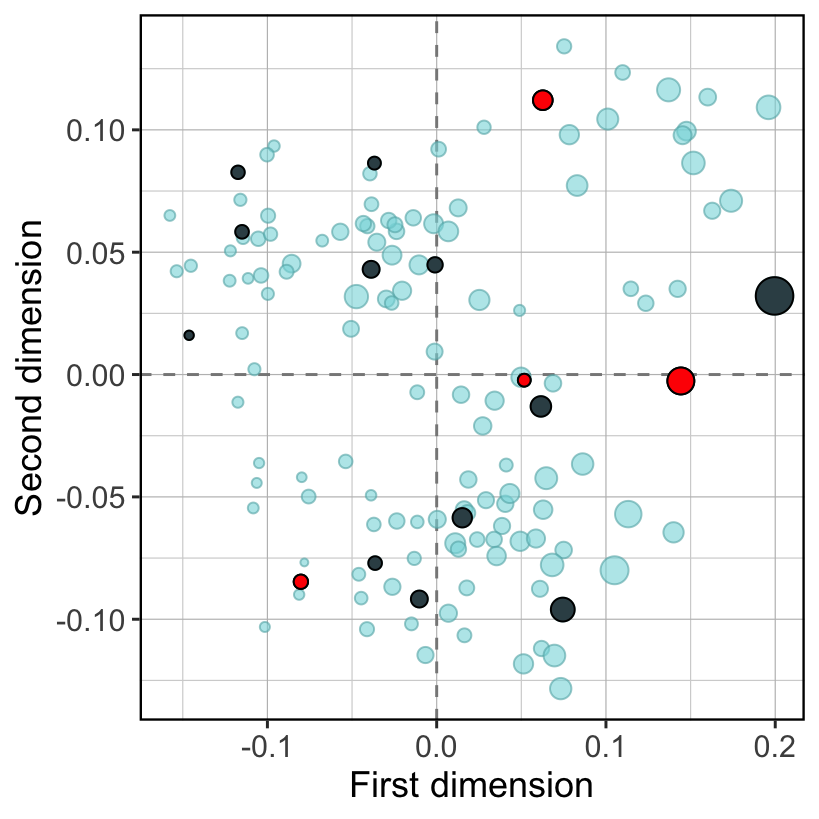

In [16]:
%%R -i df_to_R -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)


df <- df_to_R %>% 
    mutate(volume.T = (volume / 200) **2 )
top_16 <- 16
top_4 <- 4

p = ggplot() + 
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=vol_x, y=vol_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=vol_x, y=vol_y,
                           size=volume.T), 
                color='black', fill='#374E55',
                shape=21, stroke=0.5)) +
    (df %>% 
     filter(rfe_ranking <= top_4) %>%
     geom_point(mapping=aes(x=vol_x, y=vol_y,
                           size=volume.T), 
                color='black', fill='red',
                shape=21, stroke=0.5)) +
#     coord_fixed() +

    theme(legend.position = 'none', 
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')

protein_name <- 'fxa'
methodology <- 'mds_plot'
filename <- paste0('images/fxa/', paste(protein_name, methodology,  '.pdf', sep='_'))
# ggsave(filename, plot=p, width=4.1, height= 4.1) 
p

#### Colorscale scatterplot

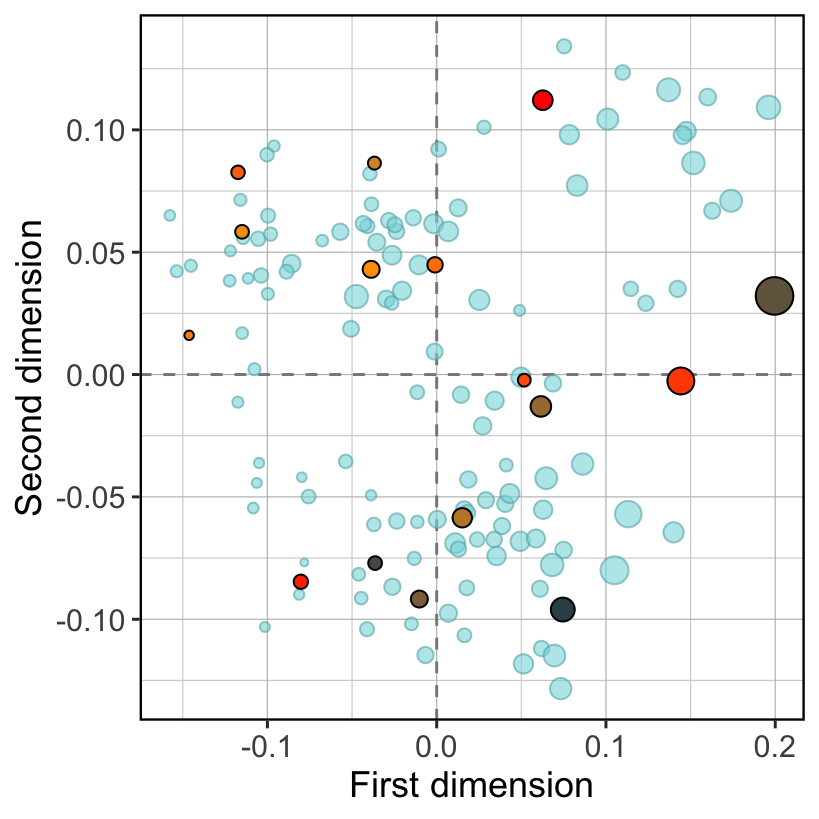

In [17]:
%%R -i df_to_R -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)

new_scale <- function(new_aes) {
   structure(ggplot2::standardise_aes_names(new_aes), class = "new_aes")
}

df <- df_to_R %>% 
    mutate(volume.T = (volume / 200) **2 )
top_16 <- 16
top_4 <- 4

p = ggplot() + 
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=vol_x, y=vol_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=vol_x, y=vol_y,
                           size=volume.T, 
                fill=rfe_ranking),
                color='black',
                shape=21, stroke=0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +
    theme( 
          legend.position = "none",
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')

protein_name <- 'fxa'
methodology <- 'mds_plot'
filename <- paste0('images/fxa/', paste(protein_name, methodology,  '.pdf', sep='_'))
ggsave(filename, plot=p, width=4.1, height= 4.1) 
p

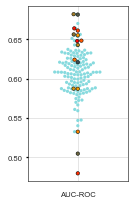

In [18]:
import matplotlib.ticker as ticker
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=["red", "orange", "#374E55"],
    N=16
)
matplotlib.cm.register_cmap("mycolormap", cmap)
sns.set(font_scale=0.7, style='whitegrid')

df_ = df_prot.copy()
df_['top_mask'] = [3 if i <= 4 else 2 if i <= 16 else 1 for i in df_['rfe_ranking']]
df_ = df_[['AUC-ROC', 'top_mask', 'rfe_ranking']].melt(id_vars=('top_mask', 'rfe_ranking'))

fig, ax = plt.subplots(figsize=(1.8, 3.22))
# fig, ax = plt.subplots(figsize=(4.1, 6.2))
# Blue dots
np.random.seed(2)
sns.swarmplot(y='value', x='variable', size=3.2,
              data=df_, ax=ax,
              color='#87DADE')
# top 16
df_top = df_.query('top_mask > 1') 
np.random.seed(2)
sns.swarmplot(y='value', x='variable', size=3.5,
              data=df_top, ax=ax,
              hue='rfe_ranking',
              edgecolor='black', linewidth=0.5,
              palette='mycolormap')
# ax.set_ylim((0.49, 0.7))
ax.set_yticks(np.arange(0.5, 0.70, .05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.tick_left()
ax.get_legend().remove()
ax.tick_params(length=2, color='black', axis='y')
ax.grid(True, linewidth=0.5)
ax.set(xlabel='', ylabel='')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.55)
    ax.spines[axis].set_edgecolor('black')
plt.savefig('./images/fxa/swarm_plot_confs.pdf') 
plt.show()

In [29]:
df_to_R_sec = df_prot[['rfe_ranking', 'secres_x', 'secres_y', 'volume']]

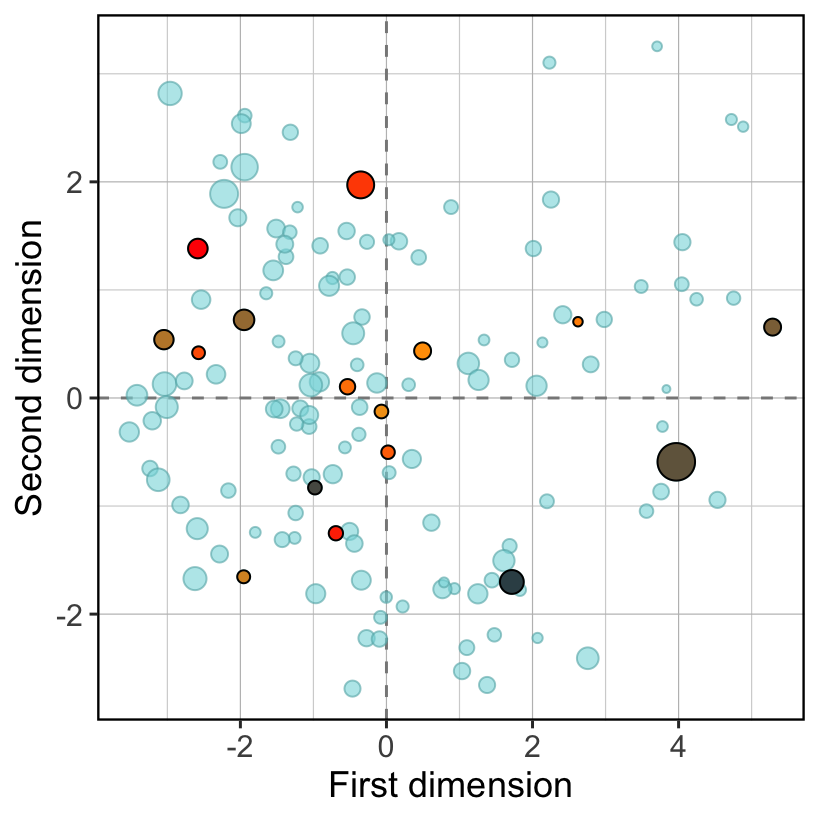

In [30]:
%%R -i df_to_R_sec -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)

new_scale <- function(new_aes) {
   structure(ggplot2::standardise_aes_names(new_aes), class = "new_aes")
}

df <- df_to_R_sec %>% 
    mutate(volume.T = (volume / 200) **2 )
top_16 <- 16
top_4 <- 4

p = ggplot() + 
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=secres_x, y=secres_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=secres_x, y=secres_y,
                           size=volume.T, 
                fill=rfe_ranking),
                color='black',
                shape=21, stroke=0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +
    theme( 
          legend.position = "none",
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')


protein_name <- 'fxa'
methodology <- 'mds_plot'
selection <- 'secstruct'
filename <- paste0('images/fxa/', paste(protein_name, methodology, selection,  '.pdf', sep='_'))
ggsave(filename, plot=p, width=4.1, height= 4.1) 
p

In [31]:
df_to_R_sec = df_prot[['rfe_ranking', 'pkt_x', 'pkt_y', 'volume']]

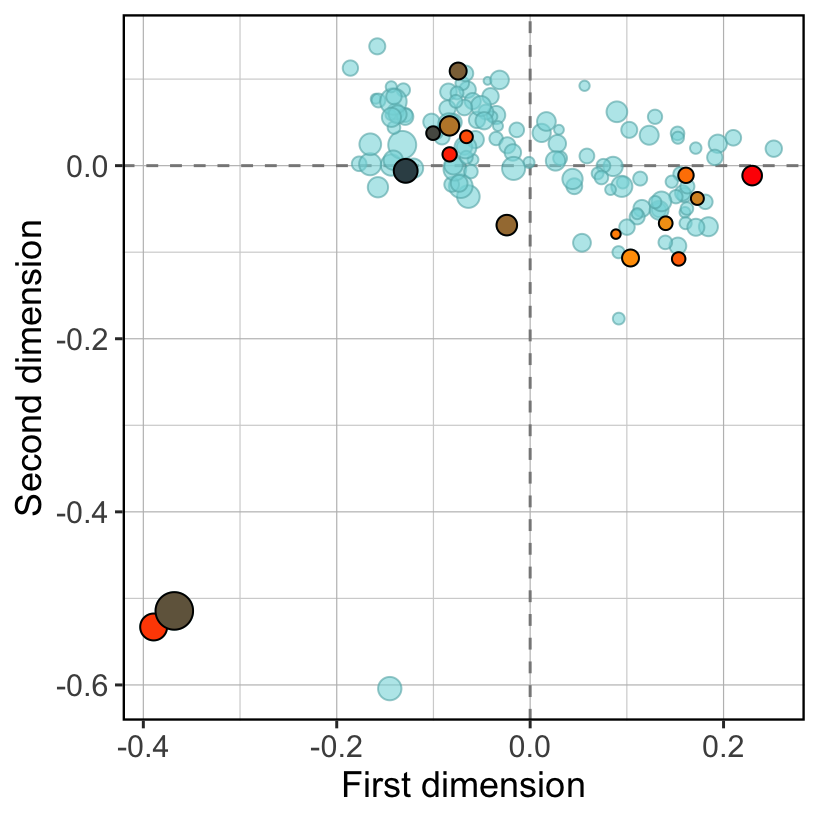

In [32]:
%%R -i df_to_R_sec -w 4.1 -h 4.1 --units in -r 200
library(ggplot2)
library(tidyverse)


df <- df_to_R_sec %>% 
    mutate(volume.T = (volume / 100) **2 )
top_4 <- 4
top_16 <- 16

p = ggplot() +
    geom_hline(yintercept= 0, linetype="dashed", color="#888888") +
    geom_vline(xintercept= 0, linetype="dashed", color="#888888") +
    (df %>% 
     geom_point(
         mapping=aes(x=pkt_x, y=pkt_y, 
                 size=volume.T),
                 stroke=0.5, shape=21,
                 colour='#61B0B3', fill='#87DADE', 
                 alpha=0.6)) + 
    (df %>% 
     filter(rfe_ranking <= top_16) %>%
     geom_point(mapping=aes(x=pkt_x, y=pkt_y,
                           size=volume.T, 
                fill=rfe_ranking),
                color='black',
                shape=21, stroke=0.5) 
    ) +
    scale_fill_gradientn(colors = c("red", "orange", "#374E55")) +

    theme(legend.position = 'none', 
              panel.border = element_rect(colour = "black", fill=NA, size=0.8),
              panel.background = element_rect(fill = "white",
                                    colour = "white",
                                    size = 1, linetype = "solid"),
              axis.title.y = element_text(size=13),
              axis.text.y=element_text(size=11, angle=0),
              panel.grid.major.y = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.y = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              axis.title.x = element_text(size=13),
              axis.text.x=element_text(size=11, angle=0),
              panel.grid.major.x = element_line(size = 0.2, linetype = 'solid', colour = "grey"), 
              panel.grid.minor.x = element_line(size = 0.2, linetype = 'solid', colour = "lightgrey"),
              plot.title = element_text(hjust = 0.5, size=11)
             ) + 
             scale_radius() +
             labs(x = 'First dimension', y = 'Second dimension')

protein_name <- 'fxa'
methodology <- 'mds_plot'
selection <- 'pocket_rmsd'
filename <- paste0('images/fxa/', paste(protein_name, methodology, selection,  '.pdf', sep='_'))
ggsave(filename, plot=p, width=4.1, height= 4.1) 
p

In [35]:
## kMeans sobre la cavidad de FXa

In [37]:
vol_tan_col_mtx

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,1.000000,0.267963,0.277135,0.280137,0.253604,0.300242,0.297615,0.260023,0.389625,0.295582,...,0.355127,0.331699,0.331178,0.330818,0.352960,0.340070,0.279970,0.278308,0.333646,0.306194
1,0.267963,1.000000,0.535714,0.469529,0.285036,0.357314,0.382023,0.285785,0.278295,0.331725,...,0.363744,0.301587,0.358379,0.344378,0.332776,0.380105,0.340235,0.416403,0.338045,0.315579
2,0.277135,0.535714,1.000000,0.467624,0.312090,0.384485,0.440863,0.304259,0.313775,0.356079,...,0.401366,0.339636,0.363383,0.379371,0.360459,0.405899,0.341084,0.451372,0.360221,0.331945
3,0.280137,0.469529,0.467624,1.000000,0.329185,0.346332,0.347772,0.339785,0.307436,0.321180,...,0.342722,0.340123,0.371990,0.348016,0.363275,0.347343,0.298754,0.363038,0.361305,0.323055
4,0.253604,0.285036,0.312090,0.329185,1.000000,0.327124,0.362539,0.459597,0.300151,0.306488,...,0.335307,0.342270,0.405250,0.373519,0.367224,0.327558,0.304221,0.318185,0.296622,0.289316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.340070,0.380105,0.405899,0.347343,0.327558,0.431336,0.413879,0.298420,0.388209,0.358720,...,0.504615,0.426189,0.546561,0.522204,0.495911,1.000000,0.412743,0.407446,0.403234,0.402203
132,0.279970,0.340235,0.341084,0.298754,0.304221,0.368728,0.394736,0.312326,0.338841,0.335678,...,0.382331,0.316630,0.415711,0.443552,0.388052,0.412743,1.000000,0.416516,0.368267,0.354348
133,0.278308,0.416403,0.451372,0.363038,0.318185,0.412754,0.476290,0.337988,0.348501,0.379604,...,0.429463,0.330679,0.380782,0.443941,0.373628,0.407446,0.416516,1.000000,0.390828,0.360210
134,0.333646,0.338045,0.360221,0.361305,0.296622,0.382918,0.348094,0.275900,0.400585,0.314132,...,0.485003,0.382100,0.417246,0.387409,0.425280,0.403234,0.368267,0.390828,1.000000,0.431335
